# Natural Language Processing with Disaster Tweets

## Define Functions and Imports

In [1]:
# Imports 
import platform
import sys
import os
import multiprocessing
from IPython.display import clear_output
from IPython.lib import deepreload 

import re
import string
import nltk
# nltk.download()
from nltk.corpus import stopwords

import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.metrics import classification_report, confusion_matrix, \
accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import plotly.express as px
import matplotlib.transforms as transforms

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_hub as hub
# import tensorflow_text
import tensorflow_addons.optimizers as optimizers
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping


import tokenization

# +++++++++++++++++++++++++++++++++++++++++++++
############## Check env details ##############
# +++++++++++++++++++++++++++++++++++++++++++++

print(f"You have {multiprocessing.cpu_count()} CPUs")
print(f"Python Platform: {platform.platform()}")
print(f"TensorFlow Version: {tf.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices("GPU")) > 0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

You have 10 CPUs
Python Platform: macOS-13.0.1-arm64-arm-64bit
TensorFlow Version: 2.9.2

Python 3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:27:43) 
[Clang 11.1.0 ]
Pandas 1.4.1
Scikit-Learn 1.0.2
GPU is available


/Users/nour/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.4.0 and strictly below 2.7.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
# Constants
EPOCHS = 30
COLORS = ['tab:blue', 'tab:orange', 'tab:green', 
          'tab:red', 'tab:purple', 'tab:brown', 
          'tab:pink', 'tab:gray', 'tab:olive', 
          'tab:cyan']
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [3]:
# Classes

# https://medium.com/geekculture/how-to-plot-model-loss-while-training-in-tensorflow-9fa1a1875a5
class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        # metrics.remove("lr")
        plt.style.use('dark_background')
        
        f, axs = plt.subplots(1, len(metrics), figsize=(24,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric, color=COLORS[-1])
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric, color=COLORS[-4], linestyle="--")
                
            axs[i].legend()
            axs[i].grid()
            axs[i].spines["top"].set_visible(False)
            axs[i].spines["right"].set_visible(False)
            

        plt.tight_layout()
        plt.show()
        plt.style.use('seaborn-whitegrid')

## Explortary Data Analysis

### Get the data

In [4]:
train_df = pd.read_csv("nlp-getting-started/train.csv")
test_df = pd.read_csv("nlp-getting-started/test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Look at one example
train_df["text"][1]

'Forest fire near La Ronge Sask. Canada'

In [6]:
# Check the test dataset
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### Exploar the datasets

/Users/nour/miniforge3/envs/tensorflow/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


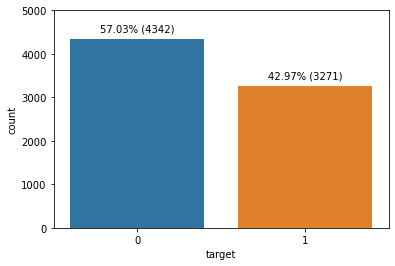

In [7]:
# Is the train dataset balanced?
splot = sns.countplot(train_df.target)

for p in splot.patches:
    splot.annotate('{:.2f}% ({:.0f})'.format((p.get_height()/len(train_df) * 100), p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', 
                   va = 'center', 
                   xytext = (0, 10), 
                   textcoords = 'offset points')

plt.ylim(0, 5000);

In [8]:
# Check the total number of samples
print(f"""
Total number of tweets: {len(test_df) + len(train_df)}
Train data is {len(train_df)} tweets, which represnts {len(train_df) / (len(test_df) + len(train_df)):.2f} of the total data
Test data is {len(test_df)} tweets, which represnts {len(test_df) / (len(test_df) + len(train_df)):.2f} of the total data
""")


Total number of tweets: 10876
Train data is 7613 tweets, which represnts 0.70 of the total data
Test data is 3263 tweets, which represnts 0.30 of the total data



In [9]:
# Visualize some random training data
import random
random_index = random.randint(0, len(train_df)-5) # get a random number 
for row in train_df[["text", "target"]][random_index:random_index+5].itertuples():
    _, text, target = row # the `_` is to get rid of the index
    print(f"Target: {target}", "(real disaster)" if target>0 else "(not real disaster)")
    print(f"Text:\n{text}\n")
    print("___________\n")

Target: 1 (real disaster)
Text:
2pcs 18W CREE Led Work Light  Offroad Lamp Car Truck Boat Mining 4WD FLOOD BEAM - Full reaÛ_ http://t.co/ApWXS5Mm44 http://t.co/DS76loZLSu

___________

Target: 0 (not real disaster)
Text:
@hellotybeeren cue the flood of people 'ironically' calling you that

___________

Target: 0 (not real disaster)
Text:
Motors Hot Deals #452 &gt;&gt; http://t.co/ED32PBviO7 10x 27W 12V 24V LED Work Light FLOOD Lamp Tractor Truck SUV UTV AÛ_ http://t.co/IfM6v6480P

___________

Target: 0 (not real disaster)
Text:
85V-265V 10W LED Warm White Light Motion Sensor Outdoor Flood Light PIR Lamp AUC http://t.co/NJVPXzMj5V http://t.co/Ijd7WzV5t9

___________

Target: 1 (real disaster)
Text:
iembot_hfo : At 10:00 AM 2 NNW Hana [Maui Co HI] COUNTY OFFICIAL reports COASTAL FLOOD #Û_ http://t.co/Gg0dZSvBZ7) http://t.co/kBe91aRCdw

___________



### Feature Engineering

We will be trying to extract more features from the dataset to develop better intuition and improve the model's predictions. The new features will be on three different levels:
1. Character
2. Word
3. Specific charecter and word

#### Character-related Features
- `char_count`, the number of characters.

In [10]:
# Get the length of each tweet
train_df["char_count"] = train_df.text.apply(lambda x: len(x))
train_df.head(3)

,id,keyword,location,text,target,char_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133


#### Word-related Features
- `word_count`, the number of words.
- `unique_word_count`, the number of unique words.
- `mean_word_length`, the average length of words in the text.

In [11]:
# Split the words of each tweet, and store them in a list (to get the wanted features)
train_df["words_list"] = train_df.text.str.split()
# Get words count
train_df["word_count"] = train_df.words_list.apply(lambda x: len(x))
# Get unique words count
train_df["unique_word_count"] = train_df.words_list.apply(lambda x: len(set(x)))
# Get the average length of the words
train_df["mean_word_length"] = train_df.words_list.apply(lambda x: np.mean([len(i) for i in x]))
train_df.head(3)

,id,keyword,location,text,target,char_count,words_list,word_count,unique_word_count,mean_word_length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,"[Our, Deeds, are, the, Reason, of, this, #eart...",13,13,4.384615
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,"[Forest, fire, near, La, Ronge, Sask., Canada]",7,7,4.571429
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,"[All, residents, asked, to, 'shelter, in, plac...",22,20,5.090909


#### Specific Charater and Word-related Features

- `stopword_count`, the number of stopwords.  --> Stop words are the filling words in a language. They contain no significant meaning, and thus could be removed from the data.
- `unstopword_count`, the number of unstopwords.
- `punc_count`, the number of punctuation characters.
- `url_count`, the number of urls in a tweet. The pattern for any url could be found [here](https://www.google.com/search?q=url+pattern+regex&oq=url+pa&aqs=chrome.0.69i59j69i57j0i4i512l4j0i512j0i4i512l2j0i512.1647j0j4&sourceid=chrome&ie=UTF-8https://www.google.com/search?q=url+pattern+regex&oq=url+pa&aqs=chrome.0.69i59j69i57j0i4i512l4j0i512j0i4i512l2j0i512.1647j0j4&sourceid=chrome&ie=UTF-8) (see also this [here](https://gist.github.com/gruber/8891611https://gist.github.com/gruber/8891611)).
- `hashtag_count`, the number of hashtag words.
- `mention_count`, the number of mention words.
- `upper_case_count`, the number of upper case characters.
- `lower_case_count`, the number of lower case characters.

In [12]:
def find_specific_word(pattern, string):
    """
    A function that uses RegEx to find words (strings) that matches a specific pattern.
    Args:
      pattern: a raw string that has the pattern we are looking for.
      string: the string we want to check if it has the pattern.
      
    Returns:
      A list of strings that matches the pattern of interest.
    """
    words = re.findall(pattern=pattern, string=string)
    
    return [x[0] for x in words]

In [13]:
# Find stop words
stop_words = set(stopwords.words("english"))
# Count the stop words in each tweet
train_df["stop_words_count"] = train_df.words_list.apply(lambda x: len([word for word in x if word in stop_words]))
# Count the other words in each tweet
train_df["non_stop_words_count"] = train_df.words_list.apply(lambda x: len([word for word in x if word not in stop_words]))

In [14]:
# Store all punctuation
punctuations = string.punctuation
# Get punctuation count for each tweet
train_df["punc_count"] = train_df.text.apply(lambda x: len([punc for punc in x if punc in punctuations]))

In [15]:
train_df.head(3)

,id,keyword,location,text,target,char_count,words_list,word_count,unique_word_count,mean_word_length,stop_words_count,non_stop_words_count,punc_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,"[Our, Deeds, are, the, Reason, of, this, #eart...",13,13,4.384615,5,8,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,"[Forest, fire, near, La, Ronge, Sask., Canada]",7,7,4.571429,0,7,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,"[All, residents, asked, to, 'shelter, in, plac...",22,20,5.090909,9,13,3


In [16]:
# Define a pattern to find all urls
url_pattern = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
# Get the number of urls in each tweet
train_df["url_count"] = train_df.text.apply(lambda x: len(find_specific_word(url_pattern, x)))
# Get the urls
train_df["url"] = train_df.text.apply(lambda x: find_specific_word(url_pattern, x))

In [17]:
# Define hashtag and mention patterns
hashtag_pattern = r"(?i)\B((\#[a-zA-Z]+))"
mention_pattern = r"(?i)\B((\@[a-zA-Z]+))"

# Get hashtags
train_df["hashtag"] = train_df.text.apply(lambda x: find_specific_word(hashtag_pattern, x))
# hashtag counts in each tweet
train_df["hashtag_count"] = train_df.hashtag.apply(lambda x: len(x))

# Get mentions
train_df["mention"] = train_df.text.apply(lambda x: find_specific_word(mention_pattern, x))
# Mentions count
train_df["mention_count"] = train_df.mention.apply(lambda x: len(x))

In [18]:
train_df.head(3)

,id,keyword,location,text,target,char_count,words_list,word_count,unique_word_count,mean_word_length,stop_words_count,non_stop_words_count,punc_count,url_count,url,hashtag,hashtag_count,mention,mention_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,"[Our, Deeds, are, the, Reason, of, this, #eart...",13,13,4.384615,5,8,1,0,[],[#earthquake],1,[],0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,"[Forest, fire, near, La, Ronge, Sask., Canada]",7,7,4.571429,0,7,1,0,[],[],0,[],0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,"[All, residents, asked, to, 'shelter, in, plac...",22,20,5.090909,9,13,3,0,[],[],0,[],0


In [19]:
# Get upper and lower case counts
train_df["upper_case_count"] = train_df.text.apply(lambda x: len([c for c in x if c.isupper()]))
train_df["lower_case_count"] = train_df.text.apply(lambda x: len([c for c in x if c.islower()]))

In [20]:
train_df.head(5)

,id,keyword,location,text,target,char_count,words_list,word_count,unique_word_count,mean_word_length,...,non_stop_words_count,punc_count,url_count,url,hashtag,hashtag_count,mention,mention_count,upper_case_count,lower_case_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,"[Our, Deeds, are, the, Reason, of, this, #eart...",13,13,4.384615,...,8,1,0,[],[#earthquake],1,[],0,10,46
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,"[Forest, fire, near, La, Ronge, Sask., Canada]",7,7,4.571429,...,7,1,0,[],[],0,[],0,5,26
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,"[All, residents, asked, to, 'shelter, in, plac...",22,20,5.090909,...,13,3,0,[],[],0,[],0,2,107
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,"[13,000, people, receive, #wildfires, evacuati...",8,8,7.125000,...,7,2,0,[],[#wildfires],1,[],0,1,49
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,"[Just, got, sent, this, photo, from, Ruby, #Al...",16,15,4.500000,...,10,2,0,[],"[#Alaska, #wildfires]",2,[],0,3,67


### Exploar the new features

In [21]:
def feature_hist(df, feature:str, hue:str, bins=15, y_lim=1500, annotiation=True, tight_layout=False):
    """
    Creates two histograms to visualize features of some text data.
    
    Args:
      df: the data frame that will be used to create the figure
      feature: the feature of interest (feature name)
      hue: the feature (or the target column) that will be used to create hue
      bins: number of bins in the histogram (defult=15)
      y_lim: the y-axis limit. It has to be set to a value of the maximum count
        plus 0.1 of this maximum count (defult=1500)
        
    """
    sns.set_palette("Set1", 8, .75) # Choose colors for the plots
    # Create a figure
    f, axes = plt.subplots(1, 2, figsize=(24,6))
    
    # Create the first histogram (without hue)
    splot1 = sns.histplot(data=df, x=feature, bins=bins, ax=axes[0])
    # Get annotation for the first histogram bins
    if annotiation:
        for p in splot1.patches:
            splot1.annotate('{:.2f}%'.format((p.get_height()/len(train_df) * 100)), 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', 
                           va = 'center', 
                           xytext = (0, 10), 
                           textcoords = 'offset points')
    
    # Create the second histogram (with hue)
    splot2 = sns.histplot(data=df, x=feature, bins=bins, hue=hue, multiple='dodge', ax=axes[1])
    # Get annotations for the second histogram
    if annotiation:
        for p in splot2.patches:
            splot2.annotate('{:.2f}%'.format((p.get_height()/len(train_df) * 100)), 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', 
                           va = 'center', 
                           xytext = (0, 10), 
                           textcoords = 'offset points')
    # Create a guide to help identify the bins in the figure (same as splot1, but with very low visability)
    splot2_ = sns.histplot(data=df, x=feature, bins=bins, ax=axes[1], color="g", alpha=0.05)

    # Get bin edges
    bin_edges = np.histogram(df[feature].to_numpy(), bins=bins)
    
    # Cosmetics
    if not tight_layout:
        splot1.set_xticks(bin_edges[1])
        splot2.set_xticks(bin_edges[1])
        
    splot1.set_title(f"{feature} histogram")
    # splot1.set_ylim(0, y_lim)
    splot1.spines["top"].set_visible(False)
    splot1.spines["right"].set_visible(False)
    
    splot2.set_title(f"{feature} histogram (with hue)")
    # splot2.set_ylim(0, y_lim)
    splot2.spines["top"].set_visible(False)
    splot2.spines["right"].set_visible(False);

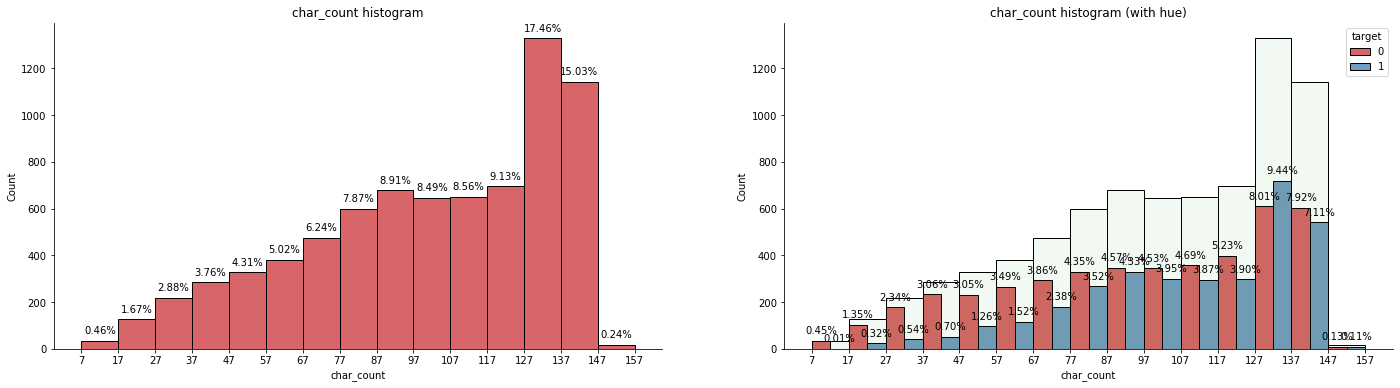

In [22]:
# Visualize character count
feature_hist(df=train_df, feature="char_count", hue="target")

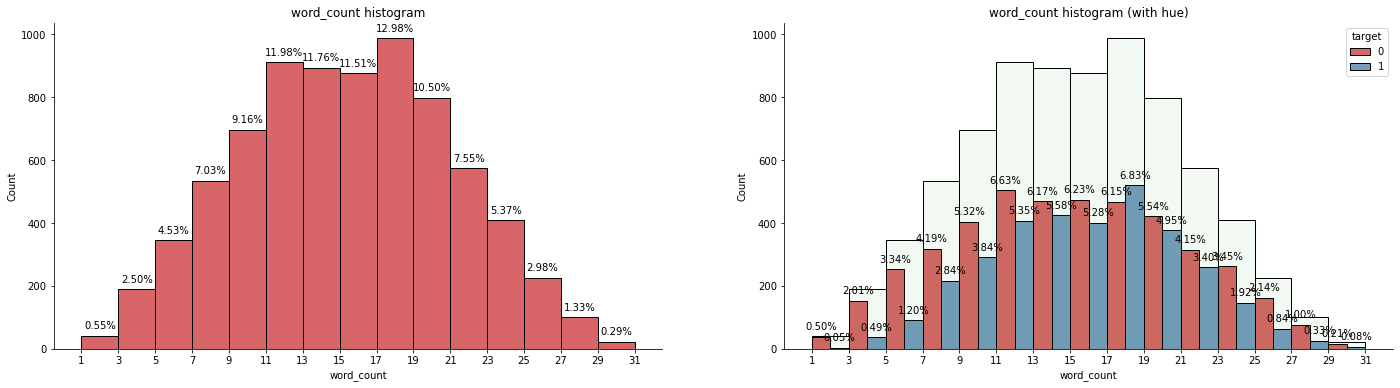

In [23]:
# Visualize word count
feature_hist(df=train_df, feature="word_count", hue="target")

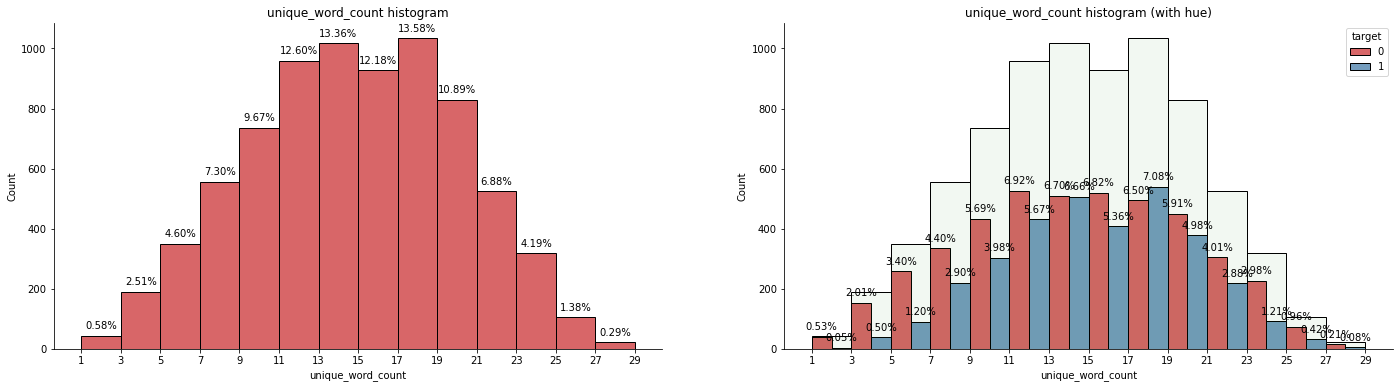

In [24]:
# Visualize unique words count
feature_hist(df=train_df, feature="unique_word_count", hue="target", bins=14)

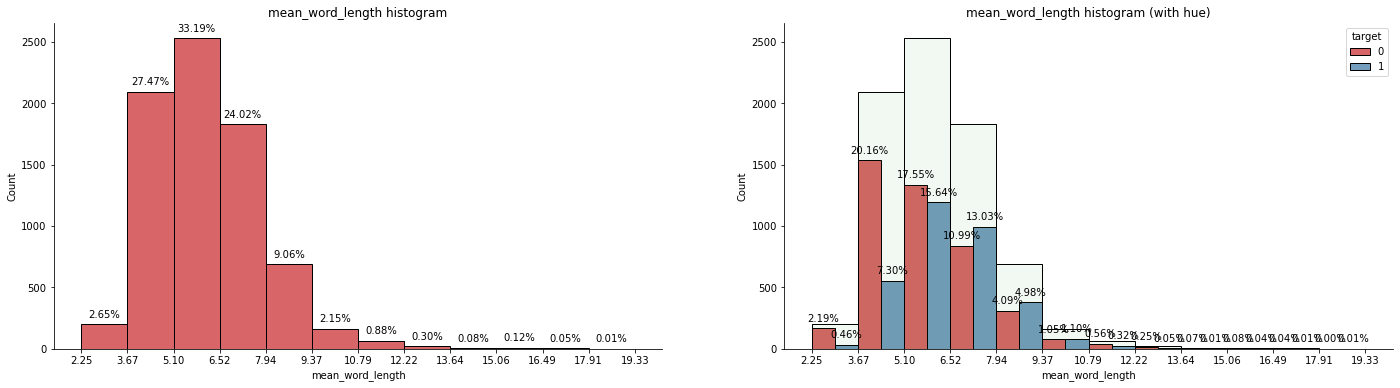

In [25]:
# Visualizing mean word length
feature_hist(df=train_df, feature="mean_word_length", hue="target", bins=12)

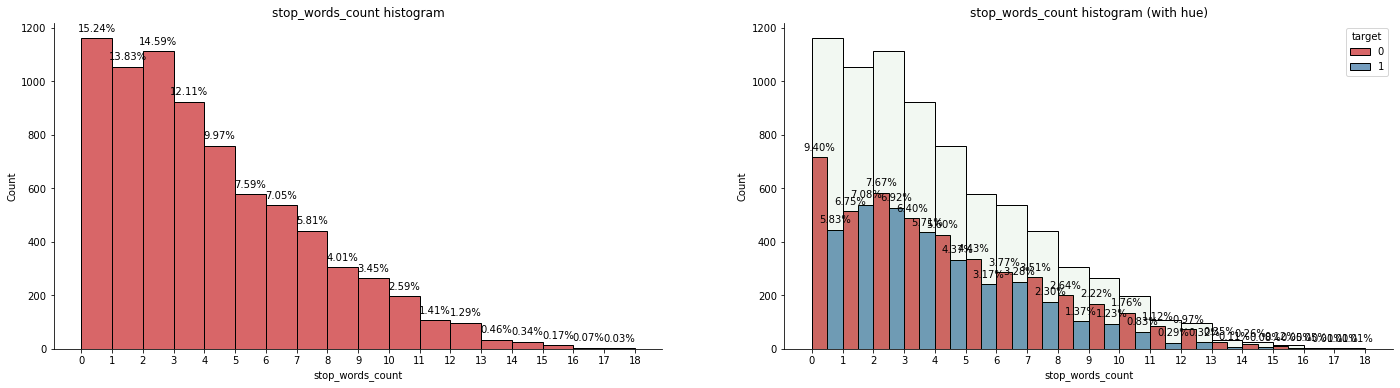

In [26]:
# Visualizing stop word counts
feature_hist(df=train_df, feature="stop_words_count", hue="target", bins=18)

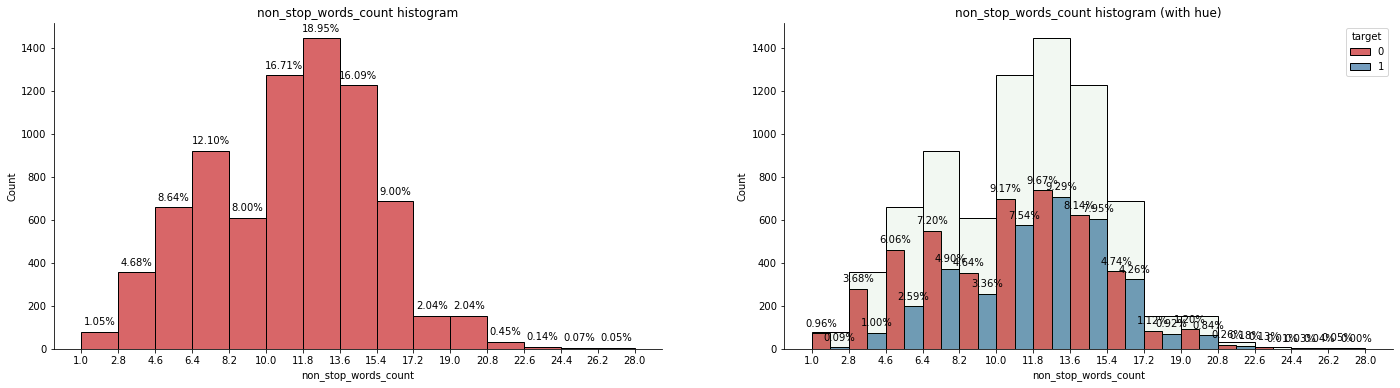

In [27]:
# Visualizing non-stop word counts
feature_hist(df=train_df, feature="non_stop_words_count", hue="target")

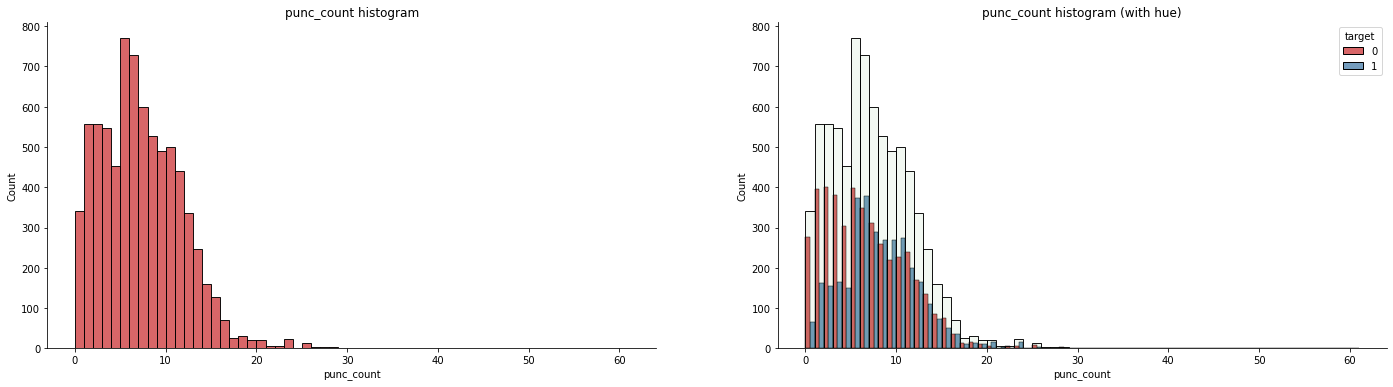

In [28]:
# Puncuation count
feature_hist(df=train_df, feature="punc_count", hue="target", bins=61, annotiation=False, tight_layout=True)

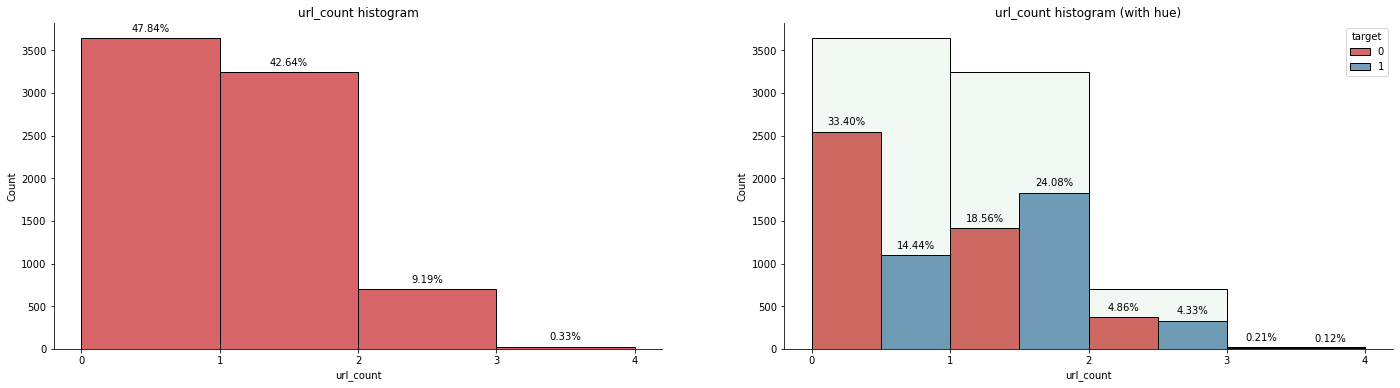

In [29]:
# Visualizing url counts
feature_hist(df=train_df, feature="url_count", hue="target", bins=4)

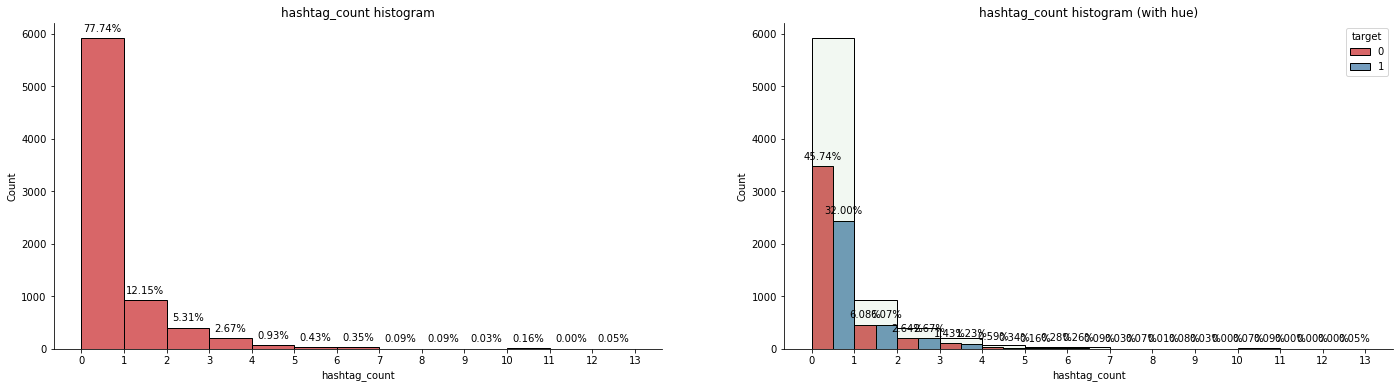

In [30]:
# The frequency of using tags in tweets
feature_hist(df=train_df, feature="hashtag_count", hue="target", bins=13)

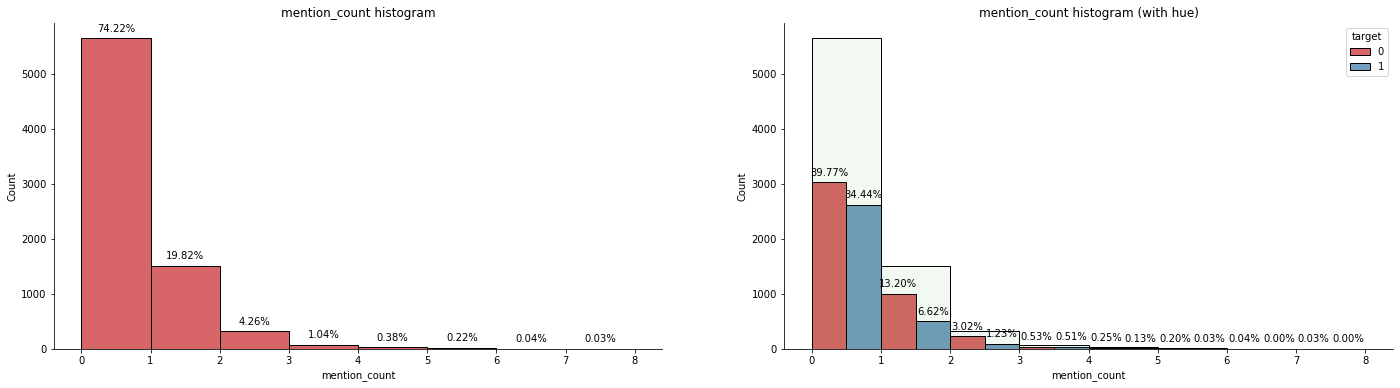

In [31]:
# Mentions frequency in the tweets
feature_hist(df=train_df, feature="mention_count", hue="target", bins=8)

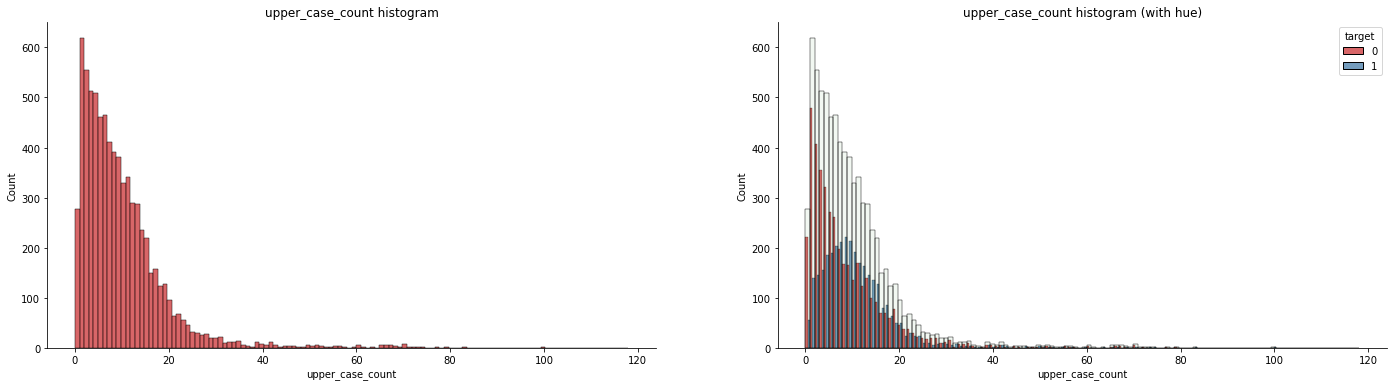

In [32]:
# Visualize upper case count
feature_hist(df=train_df, feature="upper_case_count", hue="target", bins=120, annotiation=False, tight_layout=True)

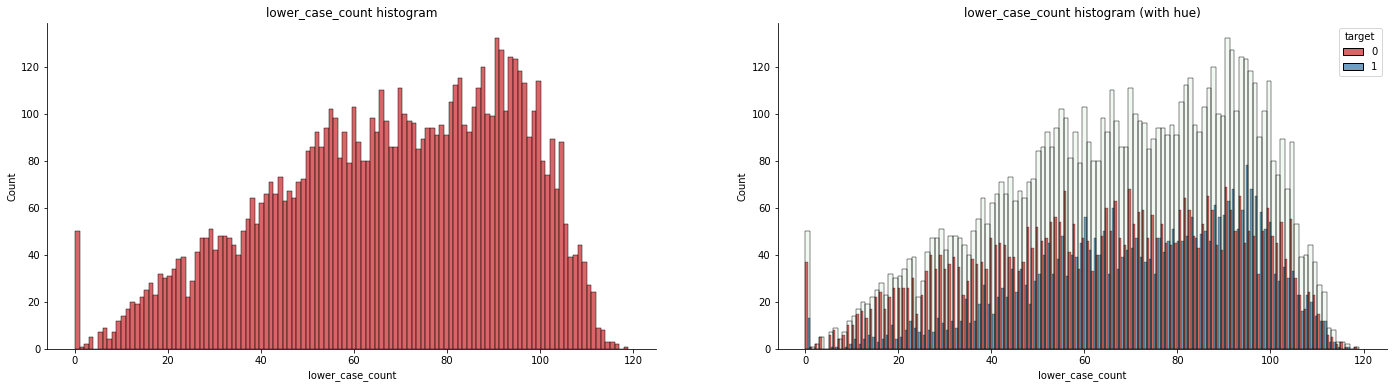

In [33]:
# Visualize lower case count
feature_hist(df=train_df, feature="lower_case_count", hue="target", bins=120, annotiation=False, tight_layout=True)

> Starting by tokenizing using spaces, then counting the words or phrases using CountVectorizer from sklearn, we will create an N-gram to find out how often a word or phrase appears in a text. 

N-gram is a sequence of N words. It could be comprimized of large block of words or smaller set of syllables. See the following example:


<figure>
  <img src="https://i.stack.imgur.com/8ARA1.png"  alt="N-Gram Example">
  <figcaption>Source: <a href=https://stackoverflow.com/questions/18193253/what-exactly-is-an-n-gram>StackOverflow</a> </figcaption>
</figure>

You can use N-Gram models for predicting the next word in a text. Another term you might hear is *skip-gram*, which is a generalization of n-grams, where the words are not required to be consecutive during text classification, but may leave gaps that are skipped over.

N-Gram takes sequence data (one word or more) as input, it then creates probablitiy distrubution of the all the possible items, and then make a prediction based on the likelihood of each item. In addiction to next-word prediction, N-Grams have other applications, such as language identification, information retrieval, and predictions in DNA sequencing.[[1]](https://deepai.org/machine-learning-glossary-and-terms/n-gram)

To calculate the probability of a word "w2" occuring after a word "w1":[[2]](https://towardsdatascience.com/understanding-word-n-grams-and-n-gram-probability-in-natural-language-processing-9d9eef0fa058)
$$ P(w2\circ w1)  = \frac{\text{Number of times } (w2 \circ w1) \text{ occur}}{\text{Number of times } w1 \text{ appeard in the corpus}} $$

In [34]:
def get_top_count_vectorizer(sentence_list, ngram, n):
    """
    Arge:
      sentence_list: a list of sentences to fit the vectorizer on
      ngram: the upper/lower boundary of the range n-values
      n: the number of words to be returned
      
    Returns:
      Two pandas series of n words used mostly in both classes
    """
    
    # Convert text into matrix of token counts
    vectorizer = CountVectorizer(ngram_range=(ngram, ngram), # The lower and upper boundary of the range of n-values for different word n-grams or char n-grams to be extracted. All values of n such such that min_n <= n <= max_n will be used. For example an ngram_range of (1, 1) means only unigrams, (1, 2) means unigrams and bigrams, and (2, 2) means only bigrams. Only applies if analyzer is not callable.
                                 stop_words='english' # a built-in stop word list for English is used.
                                )
    
    bag_of_words = vectorizer.fit_transform(sentence_list) # Fit then transform the vectorizer on the data
    
    sort_vocab = sorted(vectorizer.vocabulary_.items())
    list_vocab = [word[0] for word in sort_vocab]
    df_vectorizer = pd.DataFrame(bag_of_words.todense(), columns=list_vocab)

    # Get the target column from the main dataframe
    df_vectorizer["target"] = train_df["target"]

    # Get the most used word for each target
    df_vectorizer_0 = df_vectorizer[df_vectorizer["target"]==0].drop('target', axis=1)
    target_0_top_count = df_vectorizer_0.sum().sort_values(ascending=False)

    df_vectorizer_1 = df_vectorizer[df_vectorizer["target"]==1].drop('target', axis=1)
    target_1_top_count = df_vectorizer_1.sum().sort_values(ascending=False)
    
    return target_0_top_count[:n], target_1_top_count[:n]

In [35]:
def draw_two_hor_bar(target, suptitle):
    # Create Plot
    fig, axs = plt.subplots(figsize=(17,8))

    for x in range(2):
        p = 121 + x
        ax = plt.subplot(p)

        # Create DataFrame
        df_target = pd.DataFrame(target[x]).reset_index()
        df_target.columns = ["Word", "Count"]
        total = df_target["Count"].max()

        # Horizontal Bar Chart
        ax = sns.barplot(data=df_target, x="Count", y="Word", orient="h")

        # Text and Colors
        trans = transforms.blended_transform_factory(ax.transAxes, ax.transData)
        cmap = sns.color_palette("coolwarm", as_cmap=True)
        for i in range(10):
            if(i==0):
                ax.text((df_target["Count"][i]/total)+0.03, i, 
                             str(df_target["Count"][i]), 
                             fontweight="bold", color="black", 
                             horizontalalignment="center", verticalalignment="center",
                             transform=trans)
                ax.patches[i].set_facecolor("#937DC2")
            else:
                ax.text((df_target["Count"][i]/total)+0.03, i, 
                             str(df_target["Count"][i]), 
                             color="black", 
                             horizontalalignment="left", verticalalignment="center",
                             transform=trans)
                ax.patches[i].set_facecolor("#FF8AA5")

        # Update Axes
        ax.spines["top"].set_visible(False)  
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)  
        ax.spines["bottom"].set_visible(False)
        ax.tick_params(axis='y', which='major', pad=5)
        ax.tick_params(left=False, bottom=False)
        ax.set(xticklabels=[])
        ax.set_xlabel("")
        ax.set_ylabel("")

        # Set Title
        plt.title("Target {}".format(x), y=1.02, loc="center", fontsize=15)

    # Show
    plt.suptitle("Top 10 " + suptitle, fontsize=20, y=1.04)
    plt.tight_layout()
    plt.show()

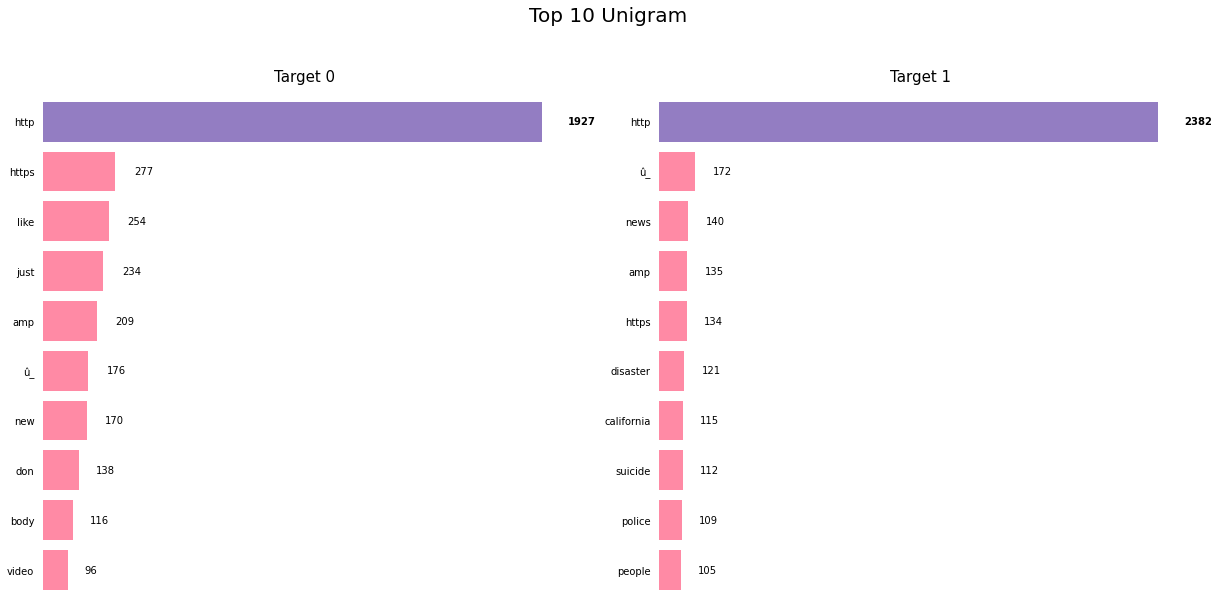

In [36]:
target_0_top_count, target_1_top_count = get_top_count_vectorizer(train_df["text"], ngram=1, n=10) # try ngram=1, 2, and 3
draw_two_hor_bar([target_0_top_count, target_1_top_count], "Unigram")

### Prepare the datasets

Since I will be using **transfer learning** I won't vectorize and embed the layers.

In [37]:
# Remove URL
train_df["cleaned_words_list"] = train_df.text # Create a new column for clean text
train_df["cleaned_words_list"] = train_df.cleaned_words_list.apply(lambda x: re.sub(url_pattern, '',x)) # Remove the urls using RegEx
# # Remove mentions and hashtags
# train_df["cleaned_words_list"] = train_df.cleaned_words_list.apply(lambda x: ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split()))
# Use lower cases only
train_df["cleaned_words_list"] = train_df.cleaned_words_list.apply(lambda x: [y.lower() for y in x.split()])
# # Remove stop words
# train_df["cleaned_words_list"] = train_df.cleaned_words_list.apply(lambda x: [word for word in x if word not in stop_words])

In [38]:
train_df_old = train_df # to avoid losing old text

In [39]:
# Update the text to be used for training
train_df = train_df_old
train_df["text"] = train_df.cleaned_words_list.apply(lambda x: " ".join(x))

In [40]:
# Shuffle our training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=101)
train_df_shuffled.head()

,id,keyword,location,text,target,char_count,words_list,word_count,unique_word_count,mean_word_length,...,punc_count,url_count,url,hashtag,hashtag_count,mention,mention_count,upper_case_count,lower_case_count,cleaned_words_list
5475,7813,quarantine,"ÌÏT: 40.707762,-74.014213",aannnnd - 'reddit will now quarantine offensiv...,0,80,"[Aannnnd, -, 'Reddit, Will, Now, Quarantine, O...",9,9,8.000000,...,8,1,[https://t.co/P1JluRGWBu],[],0,[],0,13,50,"[aannnnd, -, 'reddit, will, now, quarantine, o..."
6387,9128,suicide%20bomb,Na waffi,pic of 16yr old pkk suicide bomber who detonat...,1,107,"[Pic, of, 16yr, old, PKK, suicide, bomber, who...",16,16,5.750000,...,5,1,[http://t.co/FVXHoPdf3W],[],0,[],0,12,72,"[pic, of, 16yr, old, pkk, suicide, bomber, who..."
4343,6167,hijack,"Near Richmond, VA",another mac vuln!,0,42,"[Another, Mac, vuln!, https://t.co/OxXRnaB8Un]",4,4,9.500000,...,6,1,[https://t.co/OxXRnaB8Un],[],0,[],0,7,24,"[another, mac, vuln!]"
4524,6429,hurricane,NaN,@hurricane_dolce no prob,1,24,"[@Hurricane_Dolce, no, prob]",3,3,7.333333,...,2,0,[],[],0,[@Hurricane],1,2,18,"[@hurricane_dolce, no, prob]"
2771,3983,devastation,NaN,70 years after atomic bombs japan still strugg...,1,135,"[70, Years, After, Atomic, Bombs, Japan, Still...",19,19,6.157895,...,9,1,[http://t.co/Targ56iGBZ],[],0,[],0,15,89,"[70, years, after, atomic, bombs, japan, still..."


In [41]:
# Split data into training and validation datasets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                           train_df_shuffled["target"].to_numpy(),
                                                                           test_size=0.1,
                                                                           random_state=7)

# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

# AlBERT

In [42]:
import tokenization_albert
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [43]:
# Redefine the plotting callback
class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_epoch_begin(self, epoch, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_batch_end(self, batch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        # metrics = [x for x in logs if 'val' not in x]
        metrics = [x for x in logs]
        # metrics.remove("lr")
        # plt.style.use('dark_background')
        plt.style.use('seaborn-whitegrid')
        
        f, axs = plt.subplots(1, len(metrics), figsize=(24,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, batch + 2), 
                        self.metrics[metric], 
                        label=metric, color=COLORS[-1])
            # if logs['val_' + metric]:
            #     axs[i].plot(range(1, batch + 2), 
            #                 self.metrics['val_' + metric], 
            #                 label='val_' + metric, color=COLORS[-4], linestyle="--")
                
            axs[i].legend()
            axs[i].grid()
            axs[i].set_ylim([0, 1.1])
            axs[i].spines["top"].set_visible(False)
            axs[i].spines["right"].set_visible(False)
            
        # plt.tight_layout()
        plt.show()
        # plt.style.use('seaborn-whitegrid')

In [44]:
# Define BERT encoder function
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
        
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
        
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [58]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

# Define BERT model
def build_model(bert_layer, max_len=512):
    input_word_ids = layers.Input(shape=(max_len,),
                                 dtype=tf.int32,
                                 name="input_word_ids")
    input_mask = layers.Input(shape=(max_len,),
                             dtype=tf.int32,
                             name="input_mask")
    segment_ids = layers.Input(shape=(max_len,),
                              dtype=tf.int32,
                              name="segment_ids")
    
    sequence_output = bert_layer({"input_mask": input_mask, 
                                    "input_type_ids": segment_ids, 
                                    "input_word_ids": input_word_ids})
    clf_output = sequence_output["sequence_output"]
    x = layers.Bidirectional(layers.LSTM(1024, dropout=0.9, return_sequences=True))(clf_output)
    x = layers.Bidirectional(layers.LSTM(1024, dropout=0.9))(x)
    # x = layers.Dropout(0.2)(clf_output)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(2, activation="softmax", name="output")(x)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids],
                 outputs=out)
    
    model.compile(loss="sparse_categorical_crossentropy",
                 optimizer=Adam(learning_rate=1e-5),
                 metrics=["accuracy"])
    
    return model

In [52]:
%%time
# Get BERT model from TF Hub
module_url = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/2"
# albert_url = "https://tfhub.dev/google/albert_base/3"
bert_layer = hub.KerasLayer(module_url)

CPU times: user 12.5 s, sys: 214 ms, total: 12.7 s
Wall time: 12.6 s


In [53]:
# Prepare a tokenizer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization_albert.FullTokenizer(vocab_file, do_lower_case)

In [54]:
# Encode the data
train_input = bert_encode(texts=train_sentences,
                         tokenizer=tokenizer,
                         max_len=160)
train_labels = train_labels

val_input = bert_encode(texts=val_sentences,
                       tokenizer=tokenizer,
                       max_len=160)
val_labels = val_labels

test_input = bert_encode(texts=test_df.text.values,
                        tokenizer=tokenizer,
                        max_len=160)

In [59]:
# Build the model
model_3 = build_model(hub.KerasLayer(module_url, trainable=True), 160)
model_3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_mask (InputLayer)        [(None, 160)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 160)]        0           []                               
                                                                                                  
 input_word_ids (InputLayer)    [(None, 160)]        0           []                               
                                                                                                  
 keras_layer_5 (KerasLayer)     {'default': (None,   81130753    ['input_mask[0][0]',             
                                768),                             'segment_ids[0][0]',        

In [60]:
# Define callbacks
checkpoint_callback = ModelCheckpoint(filepath="bert-small.h5",
                                     monitor="val_accuracy",
                                     save_best_only=True,
                                     save_weights_only=True)
tensorboard_callback = TensorBoard(log_dir="logs_bert", histogram_freq=1, update_freq="batch")
reduce_lr_callback = ReduceLROnPlateau(patience=3, factor=0.1, min_lr=1e-7, verbose=1)
early_stop_callback = EarlyStopping(patience=6, verbose=1)

In [65]:
class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        metrics.remove("lr")
        plt.style.use('seaborn-whitegrid')
        
        f, axs = plt.subplots(1, len(metrics), figsize=(24,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric, color=COLORS[-2])
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric, color=COLORS[-4], linestyle="--")
                
            axs[i].legend()
            axs[i].grid()
            axs[i].spines["top"].set_visible(False)
            axs[i].spines["right"].set_visible(False)
            

        plt.tight_layout()
        plt.show()

In [ ]:
%%time
# Fit the model

history = model_3.fit(train_input,
                 train_labels,
                 validation_data=(val_input, val_labels),
                 epochs=30,
                 callbacks=[checkpoint_callback,
                            tensorboard_callback,
                            reduce_lr_callback,
                            early_stop_callback,
                           # tqdm_callback,
                           PlotLearning()
                           ],
                 batch_size=256,
                 verbose=1)


Epoch 1/30


In [ ]:
model_3.evaluate(val_input, val_labels)

In [ ]:
%%time
pred_probs_model_3 = model_3.predict(val_input)
preds_model_3 = tf.argmax(pred_probs_model_3, axis=1).numpy()

In [ ]:
# Evaluate predictions
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(f"The model's accuracy score is: {accuracy_score(val_labels, preds_model_3):.2f}")
print("\nClassification Report:")
print(classification_report(val_labels, preds_model_3))

In [ ]:
import plotly.express as px

cm_df = pd.DataFrame(data=confusion_matrix(y_true=val_labels, y_pred=preds_model_3),
            columns=class_names,
            index=class_names
                    )

fig = px.imshow(cm_df, 
                text_auto=True,
                color_continuous_scale=px.colors.sequential.Blues)
fig.update_layout(autosize=False,
                  width=400, 
                  height=400,
                  xaxis=dict(tickfont=dict(size=10), tickmode="linear"),
                  yaxis=dict(tickfont=dict(size=10), tickmode="linear"),
                  title="Tweets Classification Confusion Matrix"
                  )
fig.update_traces(hovertemplate="<br>".join([
                    "Predicted label: %{x}",
                    "True label: %{y}",
                    "Preds count: %{z}"
                    ])
                 )
# if not os.path.exists("images"):
#     os.mkdir("images")
# # fig.write_image("images/cm.png")
# fig.write_html("images/cm.html")
# fig.show()

In [ ]:
def explain_text_preds_bert(preds, explainer=explainer, random_state=101):
    wrong_preds = np.argwhere(val_labels!=preds)
    right_preds = np.argwhere(val_labels==preds)

    rng = np.random.RandomState(random_state)
    idx_right = rng.choice(right_preds.flatten())
    idx_wrong = rng.choice(wrong_preds.flatten())

    print(f"Text {Fore.GREEN}{Style.BRIGHT}(Correct Prediction): \n{val_input[idx_right]}{Style.RESET_ALL}")
    print("_"*50)
    print(f"Prediction: {class_names[pred_probs_model_3[idx_right].argmax()]} ({pred_probs_model_3[idx_right][pred_probs_model_3[idx_right].argmax()]*100:.0f}%)")
    print(f"Ground truth: {class_names[val_labels[idx_right]]} ({pred_probs_model_3[idx_right][val_labels[idx_right]]*100:.0f}%)")
    explain_truth = explainer.explain_instance(val_input[idx_right],
                                      classifier_fn=model_3.predict,
                                      labels=[val_labels[idx_right]])
    HTML(explain_truth.show_in_notebook())

    print()
    print("_"*150)
    print(f"{Fore.MAGENTA}_{Fore.RESET}"*150)
    print("_"*150)
    print()
    
    print(f"Text {Fore.RED}{Style.BRIGHT}(Wrong Prediction): \n{val_input[idx_wrong]}{Style.RESET_ALL}")
    print("_"*50)
    print(f"Prediction: {class_names[pred_probs_model_3[idx_wrong].argmax()]} ({pred_probs_model_3[idx_wrong][pred_probs_model_3[idx_wrong].argmax()]*100:.0f}%)")
    print(f"Ground truth: {class_names[val_labels[idx_wrong]]} ({pred_probs_model_3[idx_wrong][val_labels[idx_wrong]]*100:.0f}%)")
    explain_truth = explainer.explain_instance(val_input[idx_wrong],
                                      classifier_fn=model_3.predict,
                                      labels=[preds[idx_wrong]])
    HTML(explain_truth.show_in_notebook())
    
    print()
    print("_"*150)
    print(f"{Fore.MAGENTA}_{Fore.RESET}"*150)
    print("_"*150)
    print()

In [ ]:
for _ in range(10):
    explain_text_preds_bert(preds=preds_model_3, random_state=_+100)

In [ ]:
# Save submission file
submission = pd.concat([test_df, 
               pd.Series(y_pred, 
                         name="target", 
                         dtype=int)], 
               axis=1)[["id", "target"]]
submission.to_csv("submission.csv", index=False)

In [ ]:
submission

In [ ]:
y_pred

In [ ]:
y_pred = model_0.predict(test_df.text.to_numpy())
# y_pred = tf.squeeze(tf.round(y_pred))
y_pred = tf.argmax(y_pred, axis=1).numpy()

In [ ]:
class_names = ["Disaster", "Not_disaster"]

In [ ]:
cm_df = pd.DataFrame(data=confusion_matrix(y_true=val_labels, y_pred=y_pred),
            columns=class_names,
            index=class_names
                    )

In [ ]:
fig = px.imshow(cm_df, 
                text_auto=True,
                color_continuous_scale=px.colors.sequential.Blues)
fig.update_layout(autosize=False,
                  width=400, 
                  height=400,
                  xaxis=dict(tickfont=dict(size=10), tickmode="linear"),
                  yaxis=dict(tickfont=dict(size=10), tickmode="linear"),
                  title="Food Vission Confusion Matrix"
                  )
fig.update_traces(hovertemplate="<br>".join([
                    "Predicted label: %{x}",
                    "True label: %{y}",
                    "Preds count: %{z}"
                    ])
                 )
# if not os.path.exists("images"):
#     os.mkdir("images")
# # fig.write_image("images/cm.png")
# fig.write_html("images/cm.html")
# fig.show()